<a href="https://colab.research.google.com/github/dudeurv/SAM_MRI/blob/main/UNet_Model_BraTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Segmentation with U-NET


In [6]:
# Import libraries
import tarfile
import re
import imageio.v2 as iio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.ndimage
import textwrap

## Download the imaging dataset


In [19]:
!gdown https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv

# Assuming the downloaded file is a ZIP file and its name is 'downloaded_data.zip'
import zipfile
with zipfile.ZipFile('Slices.zip', 'r') as zip_ref:
    zip_ref.extractall()


Downloading...
From: https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv
To: /content/Slices.zip
100% 56.1M/56.1M [00:01<00:00, 35.9MB/s]


# Implement a dataset class

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [20]:
def normalise_intensity(image, ROI_thres=0.1):
    """
    The function identifies the ROI in the image by applying a percentile-based threshold,
    then standardizes the pixel values in this region by subtracting the mean and dividing
    by the standard deviation.

    Args:
        image (np.array): Input image as a NumPy array.
        ROI_thres (float): Percentile threshold for defining the ROI (default is 0.1).

    Returns:
        np.array: Image array with normalized intensity in the ROI.
    """
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def sort_key(filename):
    """ Extracts the numerical part from the filename and returns it for sorting. """
    numbers = re.findall(r'\d+', filename)
    return int(numbers[-1]) if numbers else filename

class BrainImageSet():
    def __init__(self, image_path, label_path, modality, deploy=False, train_ratio=0.75):
        self.image_path = image_path
        self.label_path = label_path
        self.deploy = deploy
        self.images = []
        self.labels = []
        self.image_names = []  # Store image names
        self.label_names = []  # Store label names

        image_names = sorted(os.listdir(image_path), key=sort_key)
        for image_name in image_names:
            patient_id = image_name.split('-')[2]  # Extract patient ID from filename
            idx = len(self.images)

            full_image_path = os.path.join(image_path, image_name)
            image = iio.imread(full_image_path)
            self.images.append(image)
            self.image_names.append(image_name)

            if not deploy:
                label_name = image_name.replace(modality, 'seg')
                full_label_path = os.path.join(label_path, label_name)
                label = iio.imread(full_label_path)
                self.labels.append(label)
                self.label_names.append(label_name)

    def map_labels(self, label):
        """
        Maps label values to the correct class indices.
        """
        label_map = {0: 0, 85: 1, 170: 2, 255: 3}
        mapped_label = label.copy()
        for k, v in label_map.items():
            mapped_label[label == k] = v
        return mapped_label


    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        image = normalise_intensity(self.images[idx])

        # Get its label map
        label = self.labels[idx]
        label = self.map_labels(label)

        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        images_batch, labels_batch = [], []

        idx_array = range(0, len(self.images)) # Creates an array of indices ranging from 0 to len(self.images)
        batch_idx = random.sample(idx_array, batch_size) # Randomly selects a batch_size number of indices
        for i in range(batch_size):
            image, label = self.__getitem__(batch_idx[i])
            images_batch.append(image)
            labels_batch.append(label)

        images_batch, labels_batch = np.array(images_batch), np.array(labels_batch)
        images_batch = np.expand_dims(images_batch, 1)
        return images_batch, labels_batch

# Build a U-net architecture

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.


In [21]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    # Convolution layer, a ReLU activation to add non-linearity, and Batch Normalisation
    # Bias is set as false, as Batch Normalisation would remove the bias
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  # U-Net Model involves an encoder, a bottleneck and decoder section
  def __init__(self):
    super().__init__()
    # Encoder with 4 blocks of Double_Convolution layers
    # Includes 4 sets of max pooling operations with kernel 2x2 and stride 2 for downsampling
    self.down_1 = nn.Sequential(
        conv_block(1, 16),
        conv_block(16, 16),
    )
    self.down_2 = nn.Sequential(
        conv_block(16, 32, 2),
        conv_block(32, 32),
    )
    self.down_3 = nn.Sequential(
        conv_block(32, 64, 2),
        conv_block(64, 64),
    )
    # Bottleneck
    # Includes a Double Convolution layer followed by upsampling with ConvTranspose2d
    self.bottle = nn.Sequential(
        conv_block(64, 128, 2),
        conv_block(128, 128),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
    )

    # Decoder
    # Concatinating with skip connections causes feature channels to double
    # Double_Convolution and ConvTranspose2d each causes feature channels to halve
    self.up_1 = nn.Sequential(
        conv_block(128, 64),
        conv_block(64, 64),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    self.up_2 = nn.Sequential(
        conv_block(64, 32),
        conv_block(32, 32),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    # Final Output Layer
    self.out = nn.Sequential(
        conv_block(32, 16),
        conv_block(16, 16),
        nn.Conv2d(16, 4, kernel_size=1, padding=0)
    )

  def forward(self, x):
      # Use the convolutional operators defined above to build the U-net
      # Encoder
      x1 = self.down_1(x)
      x2 = self.down_2(x1)
      x3 = self.down_3(x2)

      x4 = self.bottle(x3)

      # Decoder
      ### Insert your code ###
      x5 = torch.cat((x4, x3), dim=1)
      x6 = self.up_1(x5)
      x7 = torch.cat((x6, x2), dim=1)
      x8 = self.up_2(x7)
      x9 = torch.cat((x8, x1), dim=1)
      x10 = self.out(x9)
      return x10


# Train the segmentation model

In [22]:
# CUDA device
device = torch.device('cuda')
print('Device: {0}'.format(device))

# Build the model
model = UNet()
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
loss_fn = nn.CrossEntropyLoss(ignore_index=128)

# Create an instance of BrainImageSet
train = BrainImageSet("Slices/Train/BraTS-GLI-t1c", "Slices/Train/BraTS-GLI-seg", "t1c")
test = BrainImageSet("Slices/Test/BraTS-GLI-t1c", "Slices/Test/BraTS-GLI-seg", "t1c")

# Train the model
epochs = 10000
train_batch_size = 25
eval_batch_size = 25
start = time.time()
for epoch in range(epochs):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Fetch a batch of training data and transfer it to the device
    train_images, train_labels = train.get_random_batch(train_batch_size)
    train_images, train_labels = torch.from_numpy(train_images), torch.from_numpy(train_labels)
    train_images, train_labels = train_images.to(device, dtype=torch.float32), train_labels.to(device, dtype=torch.long)
    # Perform a forward pass through the model
    model_labels = model(train_images)

    # Note that optimizer.zero_grad() is equivalent to net.zero_grad() if it optimises all the net parameters.
    optimizer.zero_grad()

    optimizer.zero_grad() # Clear previous gradients

    unique_labels = torch.unique(train_labels)

    loss = loss_fn(model_labels, train_labels) # Compute loss


    loss.backward() # Carry out backpropagation and calculate gradients
    optimizer.step() # Update model parameters

    # Evaluate
    if epoch % 1000 == 0:
        print('--- Epoch {0}: Training loss = {1:.4f}, {2:.4f} s ---'.format(epoch, loss.item(), time.time() - start_iter))
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            test_images, test_labels = test.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)

            pred_labels = model(test_images)

            test_loss = loss_fn(pred_labels, test_labels)
            print('--- Epoch {0}: Test loss = {1:.4f} ---\n'.format(epoch, test_loss.item()))

    # Save the model
    if epoch % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(epoch)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
--- Epoch 0: Training loss = 1.3180, 0.3033 s ---
--- Epoch 0: Test loss = 1.1663 ---

--- Epoch 1000: Training loss = 0.0247, 0.3558 s ---
--- Epoch 1000: Test loss = 0.0458 ---

--- Epoch 2000: Training loss = 0.0131, 0.3483 s ---
--- Epoch 2000: Test loss = 0.0247 ---

--- Epoch 3000: Training loss = 0.0131, 0.3492 s ---
--- Epoch 3000: Test loss = 0.0181 ---

--- Epoch 4000: Training loss = 0.0030, 0.3506 s ---
--- Epoch 4000: Test loss = 0.0224 ---

--- Epoch 5000: Training loss = 0.0031, 0.3483 s ---
--- Epoch 5000: Test loss = 0.0278 ---

--- Epoch 6000: Training loss = 0.0010, 0.3527 s ---
--- Epoch 6000: Test loss = 0.0085 ---

--- Epoch 7000: Training loss = 0.0032, 0.3497 s ---
--- Epoch 7000: Test loss = 0.0383 ---

--- Epoch 8000: Training loss = 0.0009, 0.3494 s ---
--- Epoch 8000: Test loss = 0.0469 ---

--- Epoch 9000: Training loss = 0.0012, 0.3480 s ---
--- Epoch 9000: Test loss = 0.0133 ---

Training took 2110.501s in total.


In [10]:
pip install torchmetrics

# Visualise the segmentation results

Number of training MRIs: 1395
Number of testing/validation MRIs: 465
Image 0: Class-wise Dice = 0.9995138645172119, Overall Dice = 0.9995138645172119
Image 1: Class-wise Dice = 1.0, Overall Dice = 1.0
Image 2: Class-wise Dice = 0.9988889098167419, Overall Dice = 0.9988889098167419
Image 3: Class-wise Dice = 1.0, Overall Dice = 1.0
Image 4: Class-wise Dice = 0.9801909923553467, Overall Dice = 0.9801909923553467
Average Class-wise Dice: 0.995718777179718
Average Overall Dice: 0.995718777179718


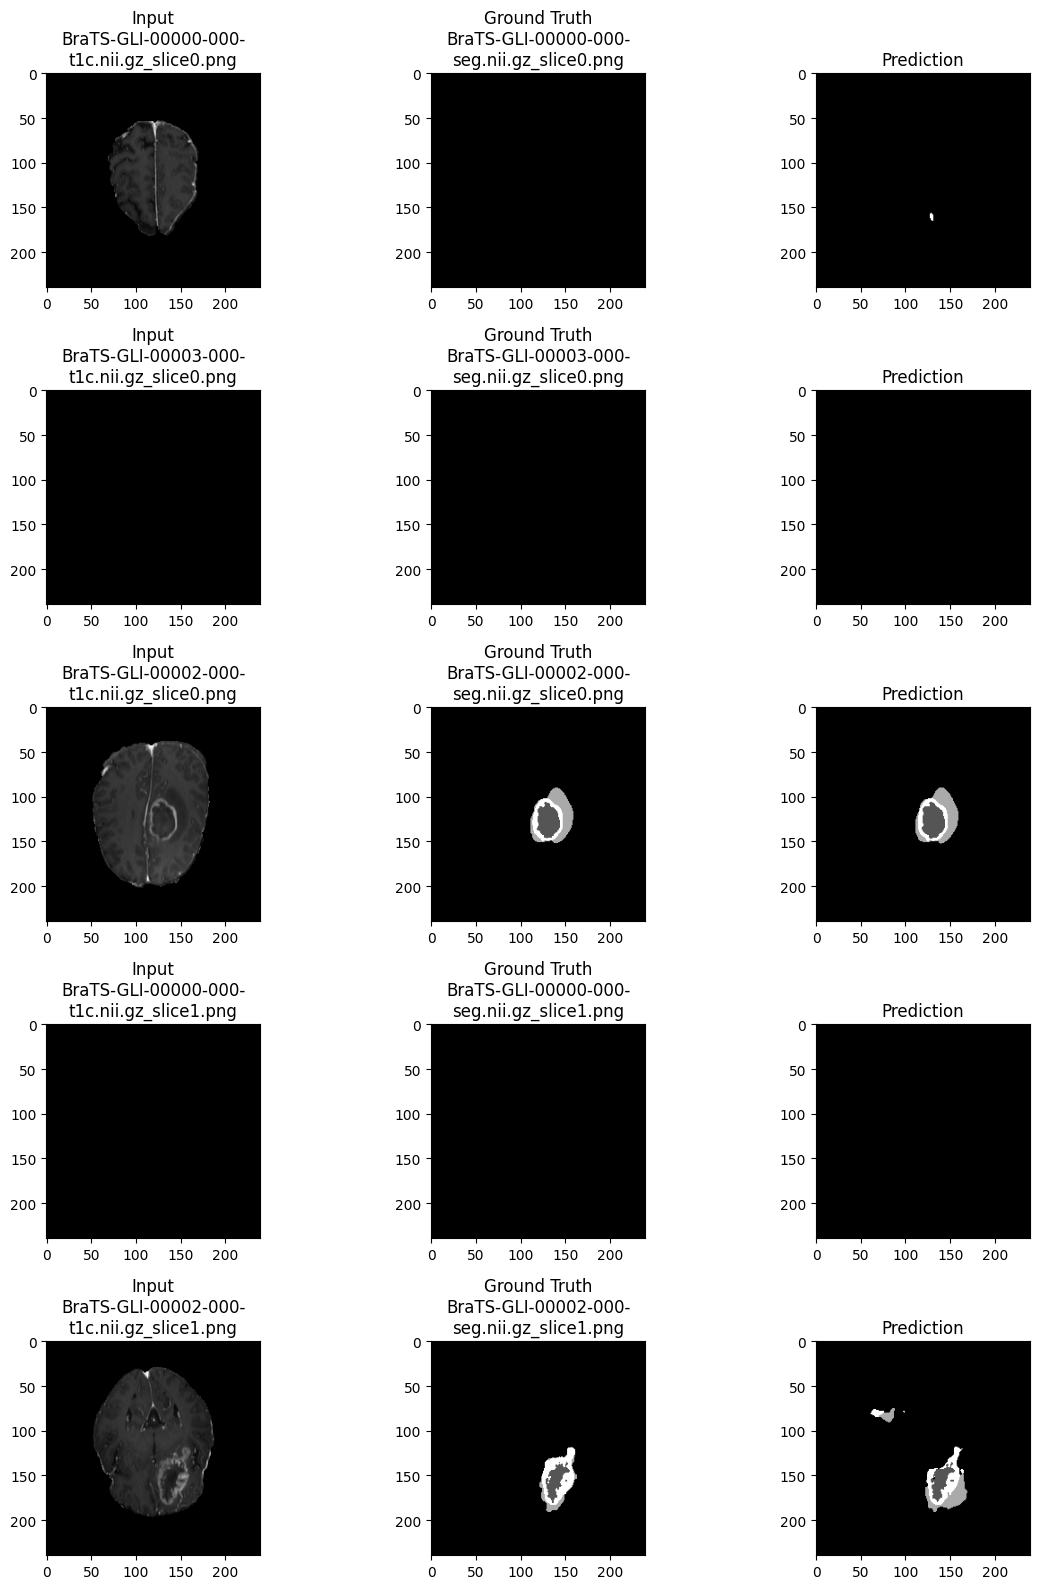

In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchmetrics import Dice
import numpy as np
import textwrap

# Dataset statistics
num_train_mris = len(train.images)
num_test_mris = len(test.images)
print(f"Number of training MRIs: {num_train_mris}")
print(f"Number of testing/validation MRIs: {num_test_mris}")

# Get a random batch of 5 test images and labels
eval_batch_size = 5
test_images, test_labels = test.get_random_batch(eval_batch_size)
test_images = torch.from_numpy(test_images).to(device, dtype=torch.float32)
test_labels = torch.from_numpy(test_labels).to(device, dtype=torch.long)

# Determine the number of classes dynamically
max_label = max(torch.max(label).item() for label in test_labels)
num_classes = max_label + 1

# Initialize Dice metrics
dice_metric_classwise = Dice(num_classes=num_classes).to(device)
dice_metric_global = Dice(num_classes=num_classes, average='micro').to(device)

# Set the model to evaluation mode
model.eval()

# Forward pass to get logits
logits = model(test_images)
prob = F.softmax(logits, dim=1)
seg = torch.argmax(prob, dim=1)

# Visualization and metric calculation
fig, axs = plt.subplots(eval_batch_size, 3, figsize=(12, 16))
class_wise_dice_scores = []
overall_dice_scores = []

for i in range(eval_batch_size):
    # Get filenames and wrap them
    image_name = test.image_names[i]
    label_name = test.label_names[i]
    wrapped_image_name = textwrap.fill(image_name, width=30)
    wrapped_label_name = textwrap.fill(label_name, width=30)

    # Visualizations
    axs[i, 0].imshow(test_images[i, 0].cpu().numpy(), cmap='gray')
    axs[i, 0].set_title(f'Input\n{wrapped_image_name}')
    axs[i, 1].imshow(test_labels[i].cpu().numpy(), cmap='gray')
    axs[i, 1].set_title(f'Ground Truth\n{wrapped_label_name}')
    axs[i, 2].imshow(seg[i].cpu().numpy(), cmap='gray')
    axs[i, 2].set_title('Prediction')

    # Dice scores
    class_wise_dice = dice_metric_classwise(seg[i].unsqueeze(0).to(device), test_labels[i].unsqueeze(0).to(device))
    overall_dice = dice_metric_global(seg[i].unsqueeze(0).to(device), test_labels[i].unsqueeze(0).to(device))

    class_wise_dice_scores.append(class_wise_dice)
    overall_dice_scores.append(overall_dice)

    print(f"Image {i}: Class-wise Dice = {class_wise_dice}, Overall Dice = {overall_dice}")

# Calculate and display averages
avg_class_wise_dice = torch.stack(class_wise_dice_scores).mean()
avg_overall_dice = torch.stack(overall_dice_scores).mean()
print(f"Average Class-wise Dice: {avg_class_wise_dice}")
print(f"Average Overall Dice: {avg_overall_dice}")

plt.tight_layout()
plt.show()
